In [129]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import tensorflow as tf

# 1. Data

In [130]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [131]:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

# 이미지들을 float32 데이터 타입으로 변경합니다.
train_images = train_images.astype('float32')
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
train_images = train_images.reshape([-1, 784])
# [0, 255] 사이의 값을 [0, 1]사이의 값으로 Normalize합니다.
train_images = (train_images - 127.5) / 127.5

In [132]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [133]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. Modeling
### Generator

In [134]:
num_input = 28 * 28
num_latent_variable = 100   # 잠재 변수 z의 차원
num_hidden = 128

def random_normal_intializer(stddev):
  return tf.keras.initializers.RandomNormal(mean=0.0, stddev=stddev, seed=None)

In [152]:

class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # 100 -> 128 -> 784
    # 히든 레이어 파라미터
    self.hidden_layer_1 = tf.keras.layers.Dense(num_hidden,
                                                activation='relu',
                                                kernel_initializer=random_normal_intializer(5e-2),
                                                bias_initializer=tf.keras.initializers.Constant(value=0.1))
    # 아웃풋 레이어 파라미터
    self.output_layer = tf.keras.layers.Dense(num_input,
                                              activation='sigmoid',
                                              kernel_initializer=random_normal_intializer(5e-2),
                                              bias_initializer=tf.keras.initializers.Constant(value=0.1))

  def call(self, x):
    hidden_layer = self.hidden_layer_1(x)
    generated_mnist_image = self.output_layer(hidden_layer)

    return generated_mnist_image



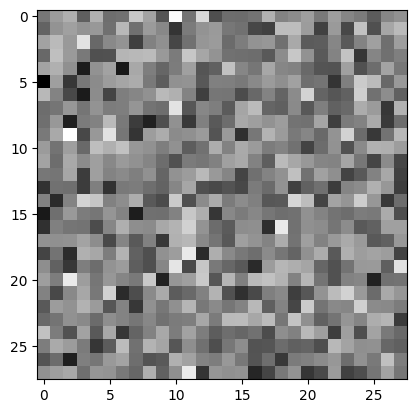

In [153]:
# 생성자(Generator) 모델을 선언합니다.
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

b=tf.reshape(generated_image, (28, 28))
plt.imshow(b, cmap='gray')

### Discriminator

In [154]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    # 784 -> 128 -> 1
    # 히든 레이어 파라미터
    self.hidden_layer_1 = tf.keras.layers.Dense(num_hidden,
                                                activation='relu',
                                                kernel_initializer=random_normal_intializer(5e-2),
                                                bias_initializer=tf.keras.initializers.Constant(value=0.1))
    # 아웃풋 레이어 파라미터
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation=None,
                                              kernel_initializer=random_normal_intializer(5e-2),
                                              bias_initializer=tf.keras.initializers.Constant(value=0.1))

  def call(self, x):
    hidden_layer = self.hidden_layer_1(x)
    logits = self.output_layer(hidden_layer)
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits


In [155]:
# 구분자(Discriminator) 모델을 선언합니다.
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.47468626]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.1013416]], dtype=float32)>)


### Loss Function and Optimizers

In [156]:
# Generator의 손실 함수를 정의합니다.
@tf.function
def generator_loss(D_fake_logits):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))         # log(D(G(z))

In [157]:
# Discriminator의 손실 함수를 정의합니다.
@tf.function
def discriminator_loss(D_real_logits, D_fake_logits):
  d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))  # log(D(x))
  d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))  # log(1-D(G(z)))
  d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

  return d_loss

In [158]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 3. Training

In [159]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [160]:
# Discriminator 최적화를 위한 function을 정의합니다.
@tf.function
def d_train_step(discriminator_model, real_image, fake_image):
  with tf.GradientTape() as disc_tape:
    D_real, D_real_logits = discriminator_model(real_image)  # D(x)
    D_fake, D_fake_logits = discriminator_model(fake_image)  # D(G(z))
    loss = discriminator_loss(D_real_logits, D_fake_logits)
  gradients = disc_tape.gradient(loss, discriminator_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))

In [161]:
# Generator 최적화를 위한 function을 정의합니다.
@tf.function
def g_train_step(generator_model, discriminator_model, z):
  with tf.GradientTape() as gen_tape:
    G = generator_model(z)
    D_fake, D_fake_logits = discriminator_model(G)  # D(G(z))
    loss = generator_loss(D_fake_logits)
  gradients = gen_tape.gradient(loss, generator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients, generator_model.trainable_variables))

In [162]:
import matplotlib.gridspec as gridspec

def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  generations = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))
  gs = gridspec.GridSpec(4, 4)
  gs.update(wspace=0.05, hspace=0.05)

  for i, sample in enumerate(generations):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    sample = tf.reshape(sample* 127.5 + 127.5, [28, 28])
    plt.imshow(sample, cmap='gray')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [163]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot history
    plt.plot(d_hist, label='disc')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()

In [164]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


In [165]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = np.random.uniform(-1., 1., [BATCH_SIZE, noise_dim]).astype('float32')

      # Discriminator 최적화를 수행하고 Discriminator의 손실함수를 return합니다.
    _, d_loss_print = d_train_step(discriminator, images, generator(noise)), discriminator_loss(discriminator(images)[1], discriminator(generator(noise))[1])

    # Generator 최적화를 수행하고 Generator 손실함수를 return합니다.
    _, g_loss_print = g_train_step(generator, discriminator, noise), generator_loss(discriminator(generator(noise))[1])

    return d_loss_print, g_loss_print

In [166]:
def train(dataset, epochs):
  d_hist, g_hist = [],[]
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      d_loss_print, g_loss_print = train_step(image_batch)
      d_hist.append(d_loss_print)
      g_hist.append(g_loss_print)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 1 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (epoch, g_hist[-1], d_hist[-1]))
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    if (epoch + 1) % 10==0:
      generate_and_save_images(generator, epoch + 1, seed)


  # 마지막 에포크가 끝난 후 생성합니다.
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plot_history(d_hist, g_hist)

반복(Epoch): 0, Generator 손실함수(g_loss): 4.972410, Discriminator 손실함수(d_loss): 0.011968
Time for epoch 1 is 2.970932722091675 sec
반복(Epoch): 1, Generator 손실함수(g_loss): 6.120900, Discriminator 손실함수(d_loss): 0.008161
Time for epoch 2 is 1.0134961605072021 sec
반복(Epoch): 2, Generator 손실함수(g_loss): 5.472383, Discriminator 손실함수(d_loss): 0.027305
Time for epoch 3 is 1.210080862045288 sec
반복(Epoch): 3, Generator 손실함수(g_loss): 4.969535, Discriminator 손실함수(d_loss): 0.051953
Time for epoch 4 is 1.0418891906738281 sec
반복(Epoch): 4, Generator 손실함수(g_loss): 4.785624, Discriminator 손실함수(d_loss): 0.044012
Time for epoch 5 is 0.9109961986541748 sec
반복(Epoch): 5, Generator 손실함수(g_loss): 4.734199, Discriminator 손실함수(d_loss): 0.033681
Time for epoch 6 is 0.9053313732147217 sec
반복(Epoch): 6, Generator 손실함수(g_loss): 4.761965, Discriminator 손실함수(d_loss): 0.025490
Time for epoch 7 is 0.9134237766265869 sec
반복(Epoch): 7, Generator 손실함수(g_loss): 4.835975, Discriminator 손실함수(d_loss): 0.019425
Time for epoch 8 is 0

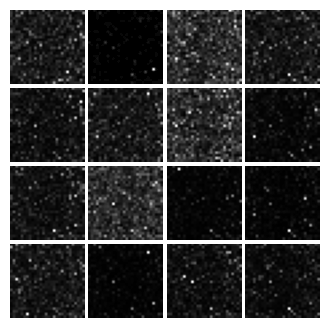

반복(Epoch): 10, Generator 손실함수(g_loss): 5.186101, Discriminator 손실함수(d_loss): 0.009378
Time for epoch 11 is 0.9309189319610596 sec
반복(Epoch): 11, Generator 손실함수(g_loss): 5.320104, Discriminator 손실함수(d_loss): 0.007561
Time for epoch 12 is 0.9100420475006104 sec
반복(Epoch): 12, Generator 손실함수(g_loss): 5.456706, Discriminator 손실함수(d_loss): 0.006162
Time for epoch 13 is 0.9196043014526367 sec
반복(Epoch): 13, Generator 손실함수(g_loss): 5.594738, Discriminator 손실함수(d_loss): 0.005076
Time for epoch 14 is 1.1231870651245117 sec
반복(Epoch): 14, Generator 손실함수(g_loss): 5.733343, Discriminator 손실함수(d_loss): 0.004213
Time for epoch 15 is 1.2520880699157715 sec
반복(Epoch): 15, Generator 손실함수(g_loss): 5.872103, Discriminator 손실함수(d_loss): 0.003523
Time for epoch 16 is 0.9208774566650391 sec
반복(Epoch): 16, Generator 손실함수(g_loss): 6.010849, Discriminator 손실함수(d_loss): 0.002965
Time for epoch 17 is 0.9125895500183105 sec
반복(Epoch): 17, Generator 손실함수(g_loss): 6.149345, Discriminator 손실함수(d_loss): 0.002508
Time

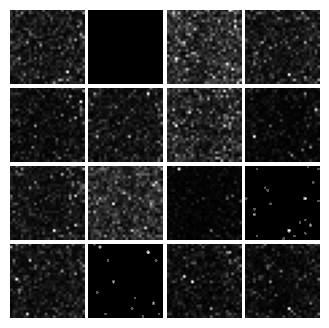

반복(Epoch): 20, Generator 손실함수(g_loss): 6.562144, Discriminator 손실함수(d_loss): 0.001562
Time for epoch 21 is 1.1046278476715088 sec
반복(Epoch): 21, Generator 손실함수(g_loss): 6.698833, Discriminator 손실함수(d_loss): 0.001338
Time for epoch 22 is 1.2375426292419434 sec
반복(Epoch): 22, Generator 손실함수(g_loss): 6.835099, Discriminator 손실함수(d_loss): 0.001152
Time for epoch 23 is 1.021850347518921 sec
반복(Epoch): 23, Generator 손실함수(g_loss): 6.970949, Discriminator 손실함수(d_loss): 0.000995
Time for epoch 24 is 0.8791863918304443 sec
반복(Epoch): 24, Generator 손실함수(g_loss): 7.106421, Discriminator 손실함수(d_loss): 0.000861
Time for epoch 25 is 0.99125075340271 sec
반복(Epoch): 25, Generator 손실함수(g_loss): 7.241571, Discriminator 손실함수(d_loss): 0.000746
Time for epoch 26 is 1.2739591598510742 sec
반복(Epoch): 26, Generator 손실함수(g_loss): 7.376390, Discriminator 손실함수(d_loss): 0.000647
Time for epoch 27 is 1.0655546188354492 sec
반복(Epoch): 27, Generator 손실함수(g_loss): 7.510881, Discriminator 손실함수(d_loss): 0.000563
Time fo

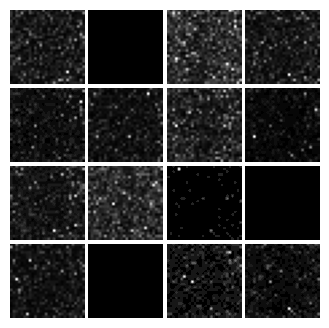

반복(Epoch): 30, Generator 손실함수(g_loss): 7.912668, Discriminator 손실함수(d_loss): 0.000372
Time for epoch 31 is 0.9273099899291992 sec
반복(Epoch): 31, Generator 손실함수(g_loss): 8.046077, Discriminator 손실함수(d_loss): 0.000325
Time for epoch 32 is 0.9028949737548828 sec
반복(Epoch): 32, Generator 손실함수(g_loss): 8.179231, Discriminator 손실함수(d_loss): 0.000284
Time for epoch 33 is 0.9010133743286133 sec
반복(Epoch): 33, Generator 손실함수(g_loss): 8.312160, Discriminator 손실함수(d_loss): 0.000248
Time for epoch 34 is 0.8997173309326172 sec
반복(Epoch): 34, Generator 손실함수(g_loss): 8.444871, Discriminator 손실함수(d_loss): 0.000217
Time for epoch 35 is 0.8989143371582031 sec
반복(Epoch): 35, Generator 손실함수(g_loss): 8.577369, Discriminator 손실함수(d_loss): 0.000190
Time for epoch 36 is 0.9123880863189697 sec
반복(Epoch): 36, Generator 손실함수(g_loss): 8.709658, Discriminator 손실함수(d_loss): 0.000166
Time for epoch 37 is 1.0824971199035645 sec
반복(Epoch): 37, Generator 손실함수(g_loss): 8.841729, Discriminator 손실함수(d_loss): 0.000145
Time

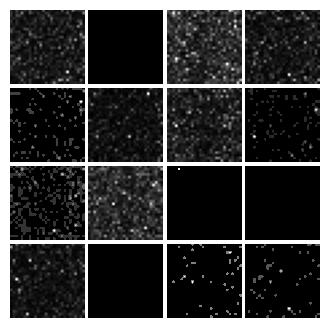

반복(Epoch): 40, Generator 손실함수(g_loss): 9.236794, Discriminator 손실함수(d_loss): 0.000098
Time for epoch 41 is 0.9413638114929199 sec
반복(Epoch): 41, Generator 손실함수(g_loss): 9.368099, Discriminator 손실함수(d_loss): 0.000086
Time for epoch 42 is 0.8967945575714111 sec
반복(Epoch): 42, Generator 손실함수(g_loss): 9.499226, Discriminator 손실함수(d_loss): 0.000075
Time for epoch 43 is 0.8966395854949951 sec
반복(Epoch): 43, Generator 손실함수(g_loss): 9.630170, Discriminator 손실함수(d_loss): 0.000066
Time for epoch 44 is 0.9148454666137695 sec
반복(Epoch): 44, Generator 손실함수(g_loss): 9.760938, Discriminator 손실함수(d_loss): 0.000058
Time for epoch 45 is 0.9177730083465576 sec
반복(Epoch): 45, Generator 손실함수(g_loss): 9.891511, Discriminator 손실함수(d_loss): 0.000051
Time for epoch 46 is 0.901958703994751 sec
반복(Epoch): 46, Generator 손실함수(g_loss): 10.021921, Discriminator 손실함수(d_loss): 0.000044
Time for epoch 47 is 0.901874303817749 sec
반복(Epoch): 47, Generator 손실함수(g_loss): 10.152165, Discriminator 손실함수(d_loss): 0.000039
Time

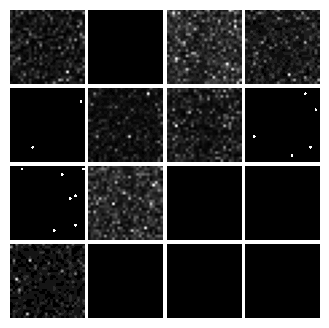

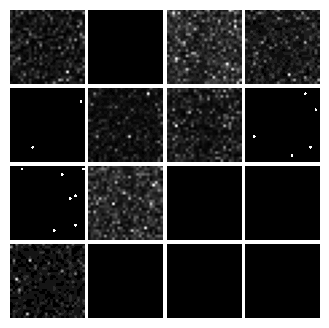

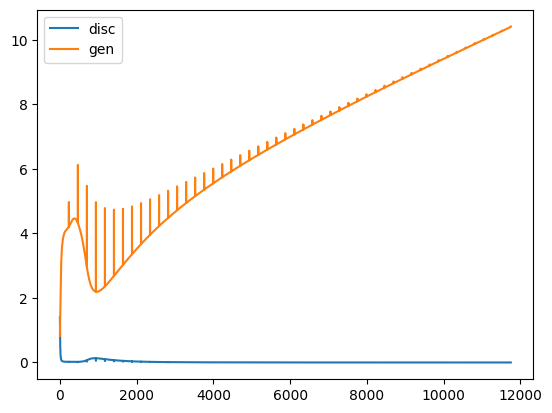

CPU times: user 1min 3s, sys: 3.32 s, total: 1min 6s
Wall time: 56.3 s


In [167]:
%%time
train(train_dataset, 50)

## 4. application

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [25]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-25-880e85e12649>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-25-880e85e12649>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [26]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>